# 02 - Introduction to seismic imaging

This notebook is the first in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic seimic, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Imaging workflow

The imaging workflow relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is auired as described in the first tutorial. In order to siplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Background velocity model**. This is a velocity model that has been obtained by processing and inverting the field data. We will look at this methods in the following tutorial as it relies on the method we are describing here. This velocity model is usually a smooth version of the true velocity model.

## Notes on the operators.

As we already describe the creation of a forward modelling operator, we will only call an utility function here. Any new operator will be fully described.

# True and smooth velocity models.

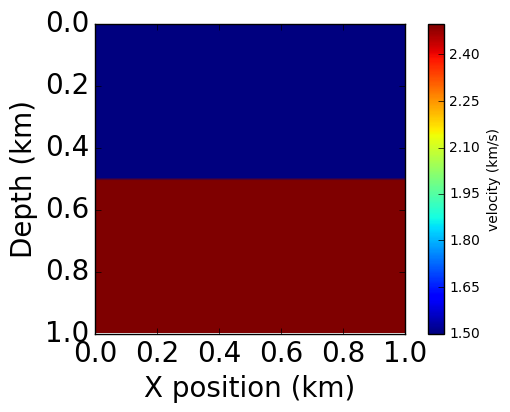

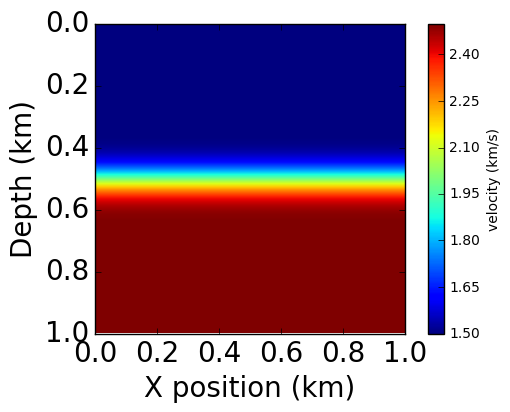

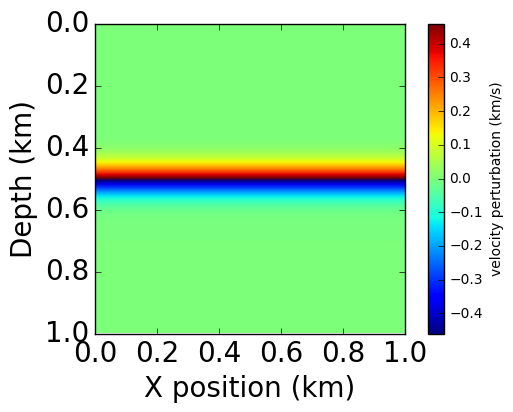

In [1]:
import numpy as np
from examples.seismic import plot_velocity, plot_perturbation
%matplotlib inline

# We import now the Model abstraction for seismic modeling
from examples.seismic import Model

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, we can create the seismic model that
# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape,
              spacing=spacing, nbpml=20)

plot_velocity(model)

# We are now smoothing the velocity model
import scipy.ndimage as ndimage

v_smooth = ndimage.gaussian_filter(v, sigma=(5, 5), order=0)

# encapsulate this properties. We also define the size of the absorbing layer as 10 grid points
model0 = Model(vp=v_smooth, origin=origin, shape=shape,
               spacing=spacing, nbpml=20)

plot_velocity(model0)

plot_perturbation(model0, model)

# True and smooth data

We can now generate the shot record correspondingto both models. The difference between this two record will be the basis of the imaging procedure. The acquisition geometry is the same as in the previous tutorial.

In [2]:
# Acquisition geometry
from examples.seismic import PointSource, Receiver
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
f0 = 0.015  # Source peak frequency is 10Hz (0.010 kHz)

dt = model.critical_dt  # Computational time step. This value is obtained from
# the maximum velocity and the grid size and is defined with the CFL condition. This is the 
# numerical condition to ensure the discrete model is stable. We will define it properly
# later on but it is required here.
nt = int(1+(tn-t0)/dt)  # Discrete time axis length

# Source initalization for a single source
def Ricker(t, f0):
    r = (np.pi * f0 * (t - 1./f0))
    return (1 - 2.*r**2) * np.exp(-r**2)

src = PointSource(name='src', npoint=1, ntime=nt, ndim=2)
src.data[:, 0] = Ricker(np.linspace(t0, tn, nt), f0)

# Set location of the source
src.coordinates.data[0, 0] = origin[0] + shape[0] * spacing[0] * 0.5
src.coordinates.data[0, 1] = 30.

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the true model
true_d = Receiver(name='reco', npoint=101, ntime=nt, ndim=2)
true_d.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
true_d.coordinates.data[:, 1] = 30.

# Receiver initialization. This one does not contain any
# data as it will be computed during the simulation and correspond
# to the smooth model
smooth_d = Receiver(name='recs', npoint=101, ntime=nt, ndim=2)
smooth_d.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
smooth_d.coordinates.data[:, 1] = 30.

In [3]:
# Forward operator 
from examples.seismic import modelling
from devito.interfaces import TimeData

forward_o = modelling(model, src, true_d)
forward_o.apply()

Explicit time dimension size (time_dim) found for TimeData symbol u, despite 
using a buffered time dimension (save=False). This value will be ignored!


DSE: extract_time_invariants [flops: 30, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 30, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 30, elapsed: 0.00] >>
     factorize [flops: 24, elapsed: 0.05] >>
     finalize [flops: 24, elapsed: 0.00]
     [Total elapsed: 0.07 s]


DLE: analyze [elapsed: 0.01] >>
     avoid_denormals [elapsed: 0.00] >>
     loop_fission [elapsed: 0.01] >>
     create_elemental_functions [elapsed: 0.01] >>
     loop_blocking [elapsed: 0.14] >>
     simdize [elapsed: 0.02] >>
     ompize [elapsed: 0.00]
     [Total elapsed: 0.18 s]


GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-501/890c783047cea256dc04c0ef7237f623ceafd750.c [0.94 s]


Section loop_p_src_1<595,1> with OI=0.73 computed in 0.000 s [Perf: 0.14 GFlops/s]


Section loop_p_reco_2<595,101> with OI=1.37 computed in 0.001 s [Perf: 1.36 GFlops/s]


Section main<595,139,139> with OI=1.46 computed in 0.066 s [Perf: 4.18 GFlops/s]


PerformanceSummary([('loop_p_src_1',
                     PerfEntry(time=0.00017199999999999976, gflopss=0.1418313953488374, oi=0.7309144295302014, itershape=[595, 1], datashape=[596, 1])),
                    ('loop_p_reco_2',
                     PerfEntry(time=0.0014529999999999912, gflopss=1.3648554714384116, oi=1.3726929530201342, itershape=[595, 101], datashape=[596, 101])),
                    ('main',
                     PerfEntry(time=0.06602999999999987, gflopss=4.178462517037718, oi=1.4553027172751698, itershape=[595, 139, 139], datashape=[596, 141, 141]))])

In [4]:
# Smooth data
forward_s = modelling(model0, src, smooth_d)
forward_s.apply(m=model0.m)

Explicit time dimension size (time_dim) found for TimeData symbol u, despite 
using a buffered time dimension (save=False). This value will be ignored!


DSE: extract_time_invariants [flops: 30, elapsed: 0.01] >>
     eliminate_inter_stencil_redundancies [flops: 30, elapsed: 0.01] >>
     eliminate_intra_stencil_redundancies [flops: 30, elapsed: 0.01] >>
     factorize [flops: 24, elapsed: 0.03] >>
     finalize [flops: 24, elapsed: 0.00]
     [Total elapsed: 0.06 s]


DLE: analyze [elapsed: 0.01] >>
     avoid_denormals [elapsed: 0.00] >>
     loop_fission [elapsed: 0.01] >>
     create_elemental_functions [elapsed: 0.01] >>
     loop_blocking [elapsed: 0.00] >>
     simdize [elapsed: 0.01] >>
     ompize [elapsed: 0.00]
     [Total elapsed: 0.03 s]


GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-501/19dced1a5b503c0168343453dfc924db014df553.c [0.30 s]


Section loop_p_src_1<595,1> with OI=0.73 computed in 0.000 s [Perf: 0.09 GFlops/s]


Section loop_p_recs_2<595,101> with OI=1.37 computed in 0.002 s [Perf: 1.02 GFlops/s]


Section main<595,139,139> with OI=1.46 computed in 0.138 s [Perf: 2.01 GFlops/s]


PerformanceSummary([('loop_p_src_1',
                     PerfEntry(time=0.00025699999999999963, gflopss=0.09492217898832699, oi=0.7309144295302014, itershape=[595, 1], datashape=[596, 1])),
                    ('loop_p_recs_2',
                     PerfEntry(time=0.001935, gflopss=1.024875968992248, oi=1.3726929530201342, itershape=[595, 101], datashape=[596, 101])),
                    ('main',
                     PerfEntry(time=0.13758099999999998, gflopss=2.0053923143457313, oi=1.4553027172751698, itershape=[595, 139, 139], datashape=[596, 141, 141]))])

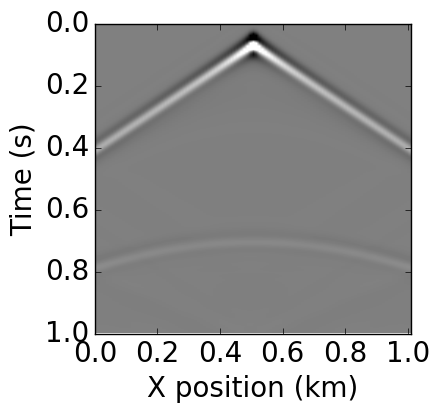

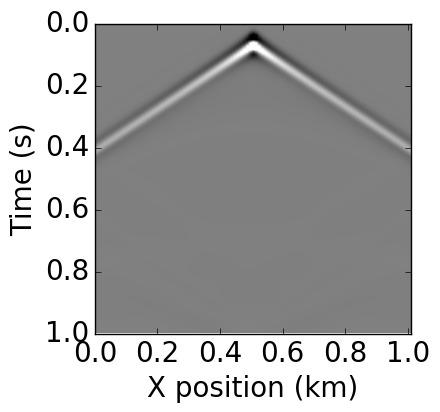

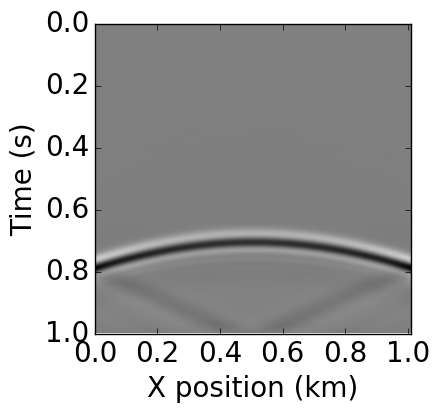

In [5]:
# Shot record for the true and smooth velocity model and the difference

from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data, origin, spacing, shape, t0, tn)

plot_shotrecord(smooth_d.data - true_d.data, origin, spacing, shape, t0, tn, diff=True)

The only difference between the smooth and the true velocity model is the value of the velocity. The dimensions of the model are unchanged. We can therefore reuse the forward modelling operator we just build and only specify the new velocity model, the shot record we want the result to be in and a new initialized wavefield.

If the shot record is not specified, the data will still be computed but will overwrite the true shot record. Concerning the initialization of a new wavefield, this comes from the simplified interface of this tutorial. In practice, a warapper would be built around the operator to reinitialize any field at runtime.

# RTM

## Least square objective imaging condition

We will consider here the least square objective. We can write the data fitting problem known as full waveform inversion (FWI) or reverse time migration (RTM) as a least square problem as follows:

\begin{equation}
min_m \Phi(m) := \frac{1}{2} \| P_r A^{-1}(m) q - d\|_2^2
\end{equation}

where $m = \frac{1}{c^2}$ is the square slowness, $A^{-1}(m)$ is the time stepping operator (inverse of the discretized wave equation), $P_r $ is the measurement operator, $q$ is the source and $d$ is the observed data.

For multiple sources it becomes a simple sum over experiments as a separable problem:

\begin{equation}
 min_m \Phi(m) := \sum_{s=1}^{n_{src}} (\frac{1}{2} \| P_{r_s} A^{-1}(m) q_s - d_s\|_2^2)
\end{equation}

We can then obtain the gradient with respect to the square slowness as

\begin{equation}
\nabla_m \Phi(m) = \sum_{s=1}^{n_{src}} ( - (\frac{dA(m)u_s}{dm})^T v_s ) = \sum_{s=1}^{n_{src}} ( \nabla_m \Phi(m)_s )
\end{equation}

where $v_s$ is the solution if the adjoint wave equation $A^{T}(m)  v = P_{r_s}^T (P_{r_s} u_s - d_s)$ and $ u_s$ is the forward wavefield solution of $A(m)u_S = q_s$. For the simple acoustic case the  gradient can be rewritten as 
\begin{equation}
\nabla_m \Phi(m)_s = - \sum_{t=1}^{nt} \frac{d^2u_s(t)}{dt^2} .v_s(t)
\end{equation}

This last equation is the imaging condition. Using it in an iterative method (gradient decent, Quasi-Newton,..) corresponds to FWI where the aim is to invert for the velocity model from an "not so good" initial guess. Once a good estimate of the background velocity model is obtained, this imaging condition is used to obtain an image of the subsurface known as RTM image.

In the following we compute the RTM image on the Marmousi synthetic 2D acoustic model from an artificial background velocity model.

In [17]:
from devito import Backward, Operator
from devito import t, time

from sympy import solve, Eq
from sympy.abc import s, h


def gradient(model, rec, grad):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeData(name="vg", shape=model.shape_domain, time_order=2, space_order=4)

    u = TimeData(name="ug", shape=model.shape_domain, time_order=2, space_order=4,
                 save=True, time_dim=nt)
    # We can now write the PDE
    pde = model.m * v.dt2 - v.laplace - model.damp * v.dt

    # This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
    # Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as
    # a time marching updating equation known as a stencil using sympy functions

    stencil = Eq(v.backward, solve(pde, v.backward)[0])
    # Finally we define the source injection and receiver read function to generate the corresponding code
    src_term = rec.inject(field=v, expr=rec * model.critical_dt ** 2 / model.m,
                          u_t=t - 1, p_t=time, offset=model.nbpml)
    
    gradient_update = Eq(grad, grad - u * v.dt2)

    op = Operator([stencil] + src_term + [gradient_update],
                  subs={s: model.critical_dt, h: model.spacing[0]},
                  time_axis=Backward)

    return op

In [26]:
from devito.interfaces import DenseData
from devito.logger import set_log_level
set_log_level('ERROR')
# Number of sources
nsrc = 11
sources = np.linspace(0, 1000, num=nsrc)

# Forward operator that saves the wavefield
forward_save = modelling(model0, src, smooth_d, save=True)

In [31]:
# Initialize a data residual object
# to the smooth model
residual = Receiver(name='recd', npoint=101, ntime=nt, ndim=2)
residual.coordinates.data[:, 0] = np.linspace(0, origin[0] + shape[0] * spacing[0], num=101)
residual.coordinates.data[:, 1] = 30.

# Gradient operator
set_log_level('ERROR')
grad = DenseData(name="grad", shape=model.shape_domain, dtype=model.m.dtype)
grad_op = gradient(model, residual, grad)
for i in range(0, nsrc):
    location = np.zeros((1, 2))
    location[0, 0] = sources[i]
    location[0, 1] = 30.
    src.coordinates.data[:] = location[:]
    # True data
    u = TimeData(name="u", shape=model.shape_domain, time_order=2, space_order=4,
                 save=False)
    forward_o.apply(u=u, m=model.m)
    # Smooth data (and save u0)
    u0 = TimeData(name="u0", shape=model.shape_domain, time_order=2, space_order=4,
                  save=True, time_dim=nt)
    time.reverse = False
    forward_save.apply(u=u0, m=model0.m)
    # gradient 
    residual.data[:] = smooth_d.data[:] - true_d.data[:]
    # plot_shotrecord(true_d.data, origin, spacing, shape, t0, tn)
    # plot_shotrecord(do.data, origin, spacing, shape, t0, tn)
    # plot_shotrecord(residual.data, origin, spacing, shape, t0, tn)
    time.reverse = True
    v = TimeData(name="v", shape=model.shape_domain, time_order=2, space_order=4)
    grad_op.apply(ug=u0, vg=v, m=model0.m, recd=residual)

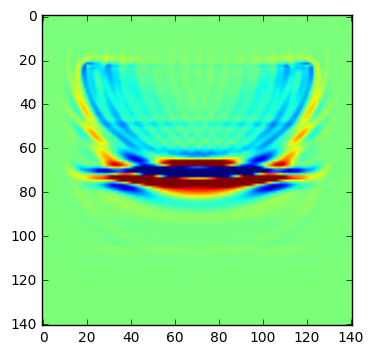

In [32]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(np.transpose(grad.data[:,:]), vmin=-1e2, vmax=1e2)